In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train_dir = 'fer2013/train/'
test_dir = 'fer2013/test/'

In [ ]:
row=48
col=48
classes = 7

In [ ]:
def count_expression(path,set_):
    dict_={}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression]=len(os.listdir(dir_))

    df = pd.DataFrame(dict_,index=[set_])
    return df

In [ ]:
train_count=count_expression(train_dir,'train_count')
print(train_count)

In [ ]:
test_count=count_expression(test_dir,'test')
print(test_count)

In [ ]:
train_count.transpose().plot(kind = "bar")
plt.title('Plot of number of images in train dataset')

In [ ]:
test_count.transpose().plot(kind = "bar")
plt.title('Plot of number of images in test dataset')

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = keras.preprocessing.image.load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.3, 
                                    horizontal_flip=True)


train_set=train_datagen.flow_from_directory(train_dir,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')



test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

In [13]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [14]:
def get_model(input_size, classes=7):
     #BUILDING the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #COMPLILING the CNN
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [19]:
our_model = get_model((row,col,1),classes)
our_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [20]:
steps_per_epoch = train_set.n // train_set.batch_size
validation_steps = test_set.n // test_set.batch_size

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose = 1, mode= "auto")

#This callback makes it so that the best weights will be saved
callback_model_checkpoint = ModelCheckpoint("best_model_weights.hdf5", save_best_only=True,
                                                               monitor='val_loss', mode = "min")

batch_size = 64 
epochs = 50

history = our_model.fit(
    x=train_set,
    validation_data=test_set,
    epochs=epochs,
    batch_size = batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2, callbacks = [callback_early_stopping, callback_model_checkpoint])


Epoch 1/50
448/448 - 722s - loss: 4.2765 - accuracy: 0.2818 - val_loss: 5.4195 - val_accuracy: 0.2839 - 722s/epoch - 2s/step
Epoch 2/50
448/448 - 736s - loss: 3.4858 - accuracy: 0.3379 - val_loss: 3.1007 - val_accuracy: 0.4030 - 736s/epoch - 2s/step
Epoch 3/50
448/448 - 814s - loss: 2.9512 - accuracy: 0.3696 - val_loss: 2.6465 - val_accuracy: 0.4152 - 814s/epoch - 2s/step
Epoch 4/50
448/448 - 1109s - loss: 2.5335 - accuracy: 0.3973 - val_loss: 2.2883 - val_accuracy: 0.4343 - 1109s/epoch - 2s/step
Epoch 5/50
448/448 - 730s - loss: 2.2112 - accuracy: 0.4272 - val_loss: 1.9825 - val_accuracy: 0.4770 - 730s/epoch - 2s/step
Epoch 6/50
448/448 - 749s - loss: 1.9739 - accuracy: 0.4427 - val_loss: 1.7699 - val_accuracy: 0.5007 - 749s/epoch - 2s/step
Epoch 7/50
448/448 - 743s - loss: 1.7901 - accuracy: 0.4671 - val_loss: 1.6231 - val_accuracy: 0.5140 - 743s/epoch - 2s/step
Epoch 8/50
448/448 - 630s - loss: 1.6528 - accuracy: 0.4887 - val_loss: 1.5444 - val_accuracy: 0.5067 - 630s/epoch - 1s/ste

mod = our_model.fit(x=train_set,
                 validation_data=test_set,
                 epochs=10,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:

#procedure to save our model
filename="our_model.h5"
our_model.save(filename)

In [25]:
from tensorflow.keras.models import load_model

In [27]:
#loading back the model
a=load_model(filename)

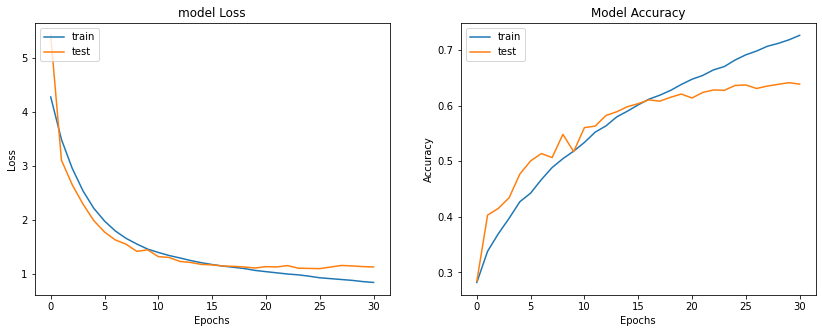

In [32]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
train_loss, train_accu = our_model.evaluate(train_set)
test_loss, test_accu = our_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 24s 209ms/step - loss: 1.1215 - accuracy: 0.6388
final train accuracy = 80.10 , validation accuracy = 63.88


Confusion Matrix
[[148  12  77 257 173 179 112]
 [ 20   0  10  35  19  14  13]
 [156   9 107 259 206 170 117]
 [284  18 201 427 353 311 180]
 [180  12 129 300 258 223 131]
 [177  12 148 305 269 214 122]
 [114   7 107 237 143 151  72]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.10      0.12      1024
       happy       0.23      0.24      0.24      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.10      0.09      0.09       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



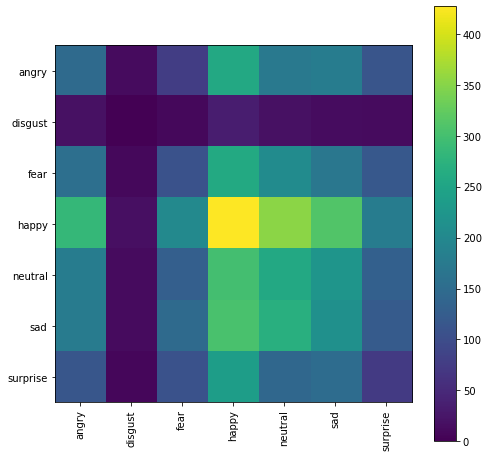

In [35]:
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

#### Using this differnt emotions of music could be played based on the mood of the person